## Code to have 2D Maxwell (with B in the direction z) using SummationByParts operators.

This is to be ported to the PIC code.

In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads

In [2]:
include("../../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")

RK4_Step! (generic function with 1 method)

In [30]:
J = (100,100)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [47]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
σx = 0.1 #dissipation strength
σy = 0.1 #dissipation strength

0.1

### Initial Data

In [32]:
#k = 2π*[3,3]
#fe(x,y) = sin(k[1]*x)*sin(k[2]*y)
function fp(x,y) 
    x0 = [0.5,0.5]
    r20 = 0.02
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r2 - r20)^2
    else
        return 0.0
    end
end
Ea = [((2-l)*(yv[j] - 0.5) - (l-1)*(xv[i] - 0.5))*fp(xv[i],yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B = [fp(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];


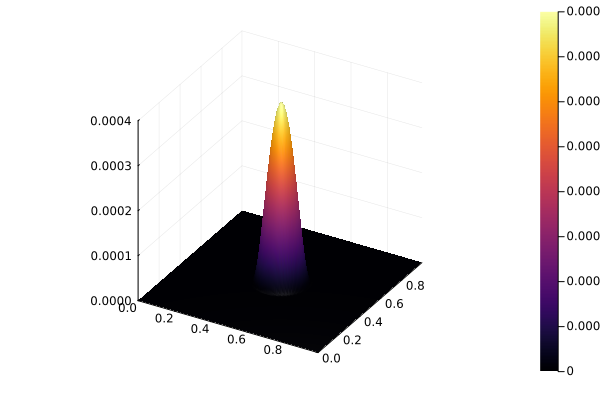

In [33]:
surface(yv,xv,B)

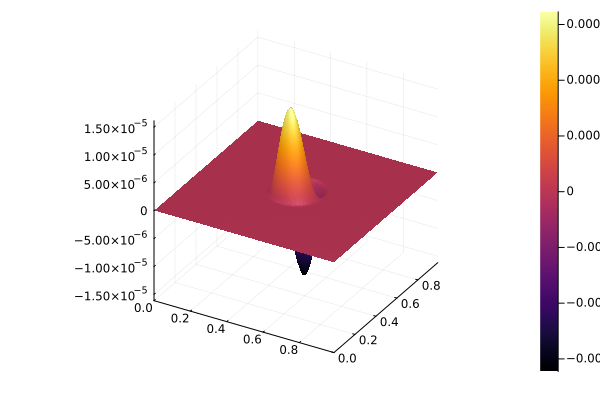

In [34]:
surface(yv,xv,Ea[2,:,:])

We upload the initial data onto the evolution vector.

In [35]:
u = Vector{Float64}(undef,3*J[1]*J[2])
du = Vector{Float64}(undef,3*J[1]*J[2])

F = reshape(u,3,J[1],J[2])

F[1:2,:,:] = Ea
F[3,:,:] = B;

Check that it is OK for this toy data.

In [9]:
@show F[1,50,50]
@show F[2,50,50]
@show F[3,1,20]

F[1, 50, 50] = -3.920400000000004e-6
F[2, 50, 50] = 3.920400000000004e-6
F[3, 1, 20] = 0.0


0.0

Define the vectors to put the space derivatives.

In [49]:
function F!(u, t, par)
    J, Dx, Δx, Dy, Δy, σx, σy, du = par
    u_a = reshape(u,(3,J...))
    Du_a = reshape(du,(3,J...))
    @threads for i in 1:J[1]
        mul!(view(Du_a,1,i,:),Dy , view(u_a,3,i,:),one(eltype(u_a)))
        mul!(view(Du_a,3,i,:),Dy , view(u_a,1,i,:),one(eltype(u_a)))
    end
    @threads for j in 1:J[2]
        mul!(view(Du_a,2,:,j),Dx , view(u_a,3,:,j),-one(eltype(u_a)))
        mul!(view(Du_a,3,:,j),Dx , view(u_a,2,:,j),-one(eltype(u_a)),one(eltype(u_a)))
    end
    
    @threads for i in 1:J[1]
        mul!(view(Du_a,1,i,:), Δy, view(u_a,1,i,:), σy, one(eltype(u_a)))
        mul!(view(Du_a,2,i,:), Δy, view(u_a,2,i,:), σy, one(eltype(u_a)))
        mul!(view(Du_a,3,i,:), Δy, view(u_a,3,i,:), σy, one(eltype(u_a)))
    end
    @threads for j in 1:J[2]
        mul!(view(Du_a,1,:,j), Δx, view(u_a,1,:,j), σx, one(eltype(u_a)))
        mul!(view(Du_a,2,:,j), Δx, view(u_a,2,:,j), σx, one(eltype(u_a)))
        mul!(view(Du_a,3,:,j), Δx, view(u_a,3,:,j), σx, one(eltype(u_a)))
    end
    
    return du[:]
end

F! (generic function with 1 method)

In [11]:

function get_Energy(u,J,Box)
    U_a = reshape(u,(3,J...))
    return norm(U_a)^2*volume(Box)/prod(J)
end

get_Energy (generic function with 1 method)

In [54]:
(t_i, t_f) = (0.0, 0.20)
M = 1000
@show dt = (t_f - t_i)/M
@show differentials(Box,J)
par = (J, Dx, Δx, Dy, Δy, σx, σy, du)
t = t_i
Energy = Array{Float64,1}(undef,M+1)
tt = Array{Float64,1}(undef,M+1)
Energy[1] = get_Energy(u,J,Box)
tt[1] = t

dt = (t_f - t_i) / M = 0.0002
differentials(Box, J) = [0.01, 0.01]


0.0

In [55]:
F[1:2,:,:] = Ea
F[3,:,:] = B;

for i in 1:M
    RK4_Step!(F!, u, 0.0, dt, par)
    t = t + dt
    tt[i+1] = t
    Energy[i+1] = get_Energy(u,J,Box)
    #println("t = $t")
    #println("Energy = $(get_Energy(u,J,Box))")
end

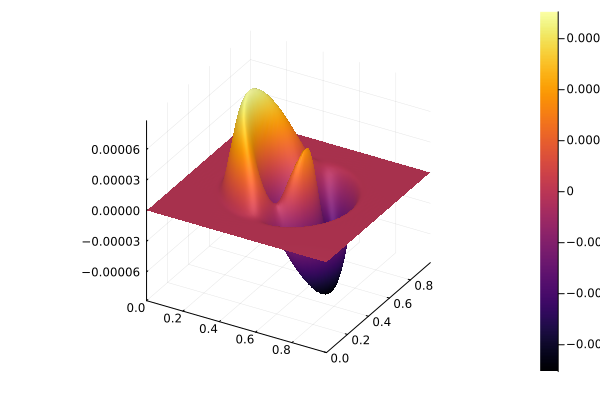

In [51]:
Ef1 = reshape(u,(3,J...))[1,:,:]

surface(yv,xv,Ef1)

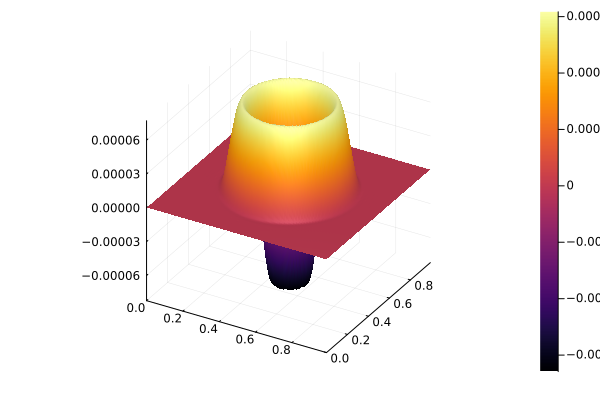

In [52]:
Bf = reshape(u,(3,J...))[3,:,:]

surface(yv,xv,Bf)

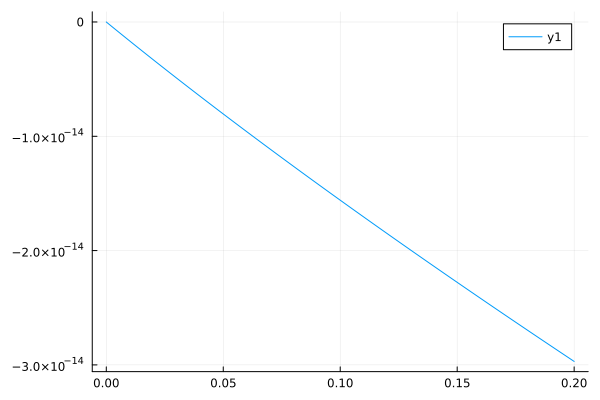

In [56]:
plot(tt,Energy .- Energy[1])

It is working very well. Now we compare with an exact solution.

### Plane wave example

In [27]:
k = 2π*[3,2]; ω = norm(k)
fe(x,y) = sin(k[1]*x + k[2]*y)
#fex(x,y) = k[1]*(-sin(k[1]*x)*cos(k[2]*y) - cos(k[1]*x)*sin(k[2]*y))
#fey(x,y) = k[2]*(-cos(k[1]*x)*sin(k[2]*y) - sin(k[1]*x)*cos(k[2]*y))

B = [fe(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];
Ea[1,:,:] = k[2]*B/ω
Ea[2,:,:] = -k[1]*B/ω



100×100 Matrix{Float64}:
 -0.0       -0.104284   -0.206922   -0.306298     …   0.206922    0.104284
 -0.155911  -0.257118   -0.35427    -0.445835         0.0522449  -0.0522449
 -0.306298  -0.400843   -0.489067   -0.569578        -0.104284   -0.206922
 -0.445835  -0.530369   -0.606539   -0.673143        -0.257118   -0.35427
 -0.569578  -0.641106   -0.702523   -0.752862        -0.400843   -0.489067
 -0.673143  -0.729131   -0.773621   -0.80591      …  -0.530369   -0.606539
 -0.752862  -0.791327   -0.817312   -0.830408        -0.641106   -0.702523
 -0.80591   -0.825489   -0.83205    -0.825489        -0.729131   -0.773621
 -0.830408  -0.830408   -0.817312   -0.791327        -0.791327   -0.817312
 -0.825489  -0.80591    -0.773621   -0.729131        -0.825489   -0.83205
  ⋮                                               ⋱              
  0.825489   0.83205     0.825489    0.80591          0.773621    0.80591
  0.830408   0.817312    0.791327    0.752862         0.817312    0.830408
  0.80591  

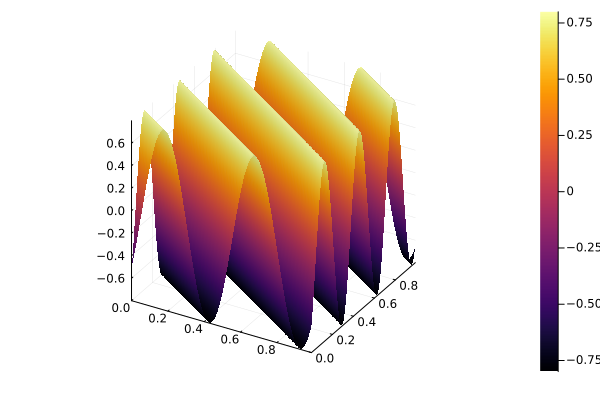

In [28]:
Be(t,ω,k) = [sin(ω*t + k[1]*xv[i] + k[2]*yv[j]) for i in 1:J[1], j in 1:J[2]];
Eae(t,ω) = k[2]/ω*Be
Eae(t,ω) = -k[1]/ω*Be

#plot(yv,xv,(Be(t_i,ω,k)-Bf))
surface(yv,xv,(Be(t_f,ω,k)-Bf))
#surface(xv,xv,(Bf))

#Bf

In [29]:
norm(Be(t_f,ω,k)-Bf)

56.54813499393249

### Results convergence (for the plane wave):

For J=(1000,1000), k = 2π[3,2]

norm(Be(t_f,ω,k)-Bf) = 7.032906051043551e-5
